# PLN Assignment 1

In the scope of the DARGMINTS project, an annotation project was carried out which consisted of annotating argumentation structures in opinion articles published in the Público newspaper. The annotation included several layers:

Selecting text spans that are taken to have an argumentative role (either as premises or conclusions of arguments) -- these are Argumentative Discourse Units (ADU).
Connecting such ADUs through support or attack relations.
Classifying the propositional content of ADUs as propositions of fact, propositions of value, or propositions of policy; within propositions of value, distinguish between those with a positive (+) or negative (-) connotation.
In a proposition of fact, the content corresponds to a piece of information that can be checked for truthness. This does not usually happen with propositions of value, which denote value judgments with a strong subjective nature; often, they also have a (positive or negative) polarity attached. A proposition of policy prescribes or suggests a certain line of action, often mentioning the agents or entities that are capable of carrying out such policies.

The aim of this assignment is to build a classifier of types of ADUs, thus focusing on the last annotation step described above. For that, you have access to two different files:

A file containing the content of each annotated ADU span and its 5-class classification: Value, Value(+), Value(-), Fact, or Policy. For each ADU, we also know the annotator and the document from which it has been taken.
A file containing details for each opinion article that has been annotated, including the full article content.
Besides ADU contents, you can make use of any contextual information provided in the corresponding opinion article.

Each opinion article has been annotated by 3 different annotators. For that reason, you will find in the ADU file an indication of which annotator has obtained the ADU. It may happen that the same ADU has been annotated by more than one annotator. When that is the case, they do not necessarily agree on the type of proposition.

How good a classifier (or set of classifiers) can you get? Don't forget to properly split the dataset in a sensible manner, so that you have a proper test set. Start by obtaining an arbitrary baseline, against which you can then compare your improvements.

## Importing the data

In order to fulfill this NLP task we will use `pandas`, `sklearn`, `nltk`, `numpy`, `matplotlib`, `seaborn` and other Python libraries


In [2]:
import pandas as pd

ADUs = pd.read_excel("data/OpArticles_ADUs.xlsx")
articles = pd.read_excel("data/OpArticles.xlsx")

ADUs.isnull().values.any() #check NaNs


False

## Exploratory analysis
Firstly (since the dataset does not contains NaN's or missing values), we need to determine the class distribution for this classification problem.
Since we have a NLP classification task, it might also be relevant to do some text characterization.

In [3]:
ADUs["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64

(array([8102.,    0., 3663.,    0.,    0., 2900.,    0., 1411.,    0.,
         667.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

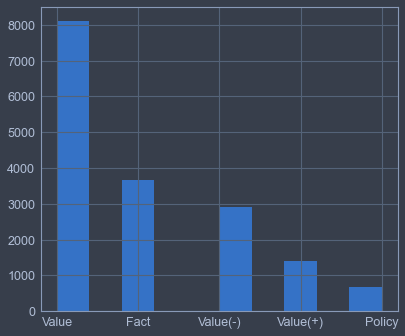

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
from jupyterthemes import jtplot

jtplot.style(theme='onedork')
plt.hist(ADUs["label"])

Some text spans were annotated by more than one annotator. Therefore, it may be the case that some text spans have different labels, which may harm the training phase.

<AxesSubplot:xlabel='annotator', ylabel='Count'>

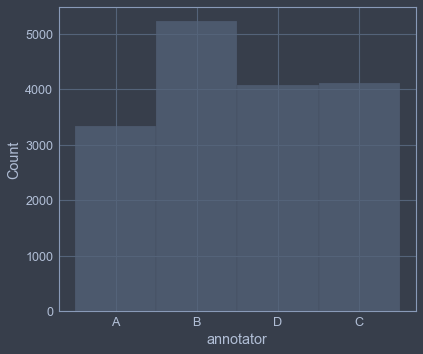

In [14]:
sb.histplot(ADUs["annotator"])

## Wordcloud per topic

# Wordcloud for the articles

In [3]:
import numpy as np

unique_spans = np.unique(ADUs[['article_id', 'ranges']].values)
(unique_spans.shape, ADUs["tokens"].shape)

((12302,), (16743,))

As we can see, more than 4000 text spans were evaluated by more than one annotator. Now let's check how many of these text spans receive different labels

## Data preparation

The next step is to cleanup the dataset, applying text normalization techniques:
 - Removing non-alphabetic chars
 - Lowercasing
 - Removing stop words
 - Stemming/lemmatization
 
However, before applying these techniques, let's try to remove the repeated annotations that may confuse the classifiers on the future steps. In order to decide which is the correct label for each (article_id, range) pair, we compute the majority.

In [4]:
grouped_df = ADUs.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    final_label = max(dict_counts.items(), key=lambda x: x[1])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(final_label[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label"])
dataset


,tokens,label
0,presumo que essas partilhas tenham gerado um e...,Value
1,essas partilhas tenham gerado um efeito bola d...,Value
2,o post não tardou a chegar ao conhecimento da ...,Value
3,esta questão ter [justificadamente] despertado...,Value
4,a ocasião propicia um debate amplo na sociedad...,Value
...,...,...
12016,eticamente é reprovável,Value(-)
12017,"eticamente é reprovável e, o bom senso, aconse...",Value
12018,"o bom senso, aconselha a não o fazer",Value
12019,Um presidente de câmara pode ter a sua preferê...,Value


In [7]:
print(ADUs["label"].value_counts())
dataset["label"].value_counts()

Value       8102
Fact        3663
Value(-)    2900
Value(+)    1411
Policy       667
Name: label, dtype: int64


Value       5748
Fact        3001
Value(-)    1872
Value(+)     889
Policy       511
Name: label, dtype: int64

We managed to reduce the amount of rows in the dataframe -> some of them had repeated/conflictuous labels. 

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer # portuguese stemmer
corpus = []
stemmer = RSLPStemmer()
for i in range(0, dataset['tokens'].size):
    # get review and remove non alpha chars
    review = re.sub('[^a-zA-Z]', ' ', dataset['tokens'][i])
    # to lower-case
    review = review.lower()
    # split into tokens, apply stemming and remove stop words
    review = ' '.join([stemmer.stem(w) for w in review.split() if not w in set(stopwords.words('portuguese'))])
    corpus.append(review)

#print(corpus)

## POS-tagging

## Generating a data set

We need to transform the corpus into a collection that can be handled by a machine learning model. We will be using `sklearn`'s TfidfVectorizer class

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#set max_features = 10000 to select k features with the highest corpus frequency
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df = 2)
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)
X

(12021, 22637)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(vectorizer.get_feature_names())

In [8]:
y = dataset["label"]
print(y.shape)
print(y.head())

(12021,)
0    Value
1    Value
2    Value
3    Value
4    Value
Name: label, dtype: object


## Splitting the dataset into training and testing

The next step is to split the dataset into training and testing. We will be using a 80%-20% split. Since classes are unbalanced (*Value* examples are significantly more abundant than *Policy* examples), we need to stratify both sets -> try to get a similar class distribution for each set.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

In [21]:
from sklearn.feature_selection import SelectKBest, chi2

n_features = 5000

#X_new = SelectKBest(chi2, k=n_features).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape

(9616, 8667)

## Training the models


### Naive Bayes
To start off, we will train a single (`Naive Bayes`) classifier that evaluates the likelihood of a document being of one of the 5 classes. This will set the baseline for which the improvements will be measured.


In [17]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Accuracy score:  0.49480249480249483


C:\Users\caion\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


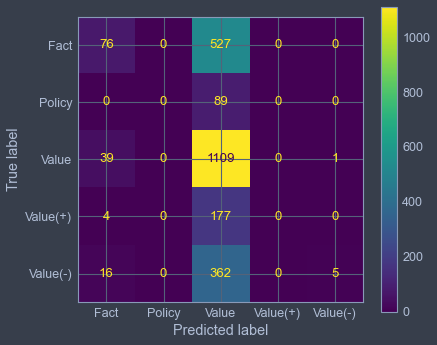

,Precision,Recall,F1
Fact,0.562963,0.126036,0.205962
Policy,0.000000,0.000000,0.000000
Value,0.489841,0.965187,0.649868
Value(+),0.000000,0.000000,0.000000
Value(-),0.833333,0.013055,0.025707


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    metrics_df = pd.DataFrame({"Precision": precision_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "Recall": recall_score(y_test, y_pred, labels = classes, average = None).tolist(),
                              "F1": f1_score(y_test, y_pred, labels = classes, average = None).tolist()},
                             index = classes)
    
    plt.show()
    return metrics_df.head()
    
print_metrics(y_test, y_pred, clf.classes_)

Since some classifiers like SVM and Logistic Regression cannot handle multi-class classification, let's use the One vs Rest classifier. This way, we can transform this problem into a binary classification problem -> one classifier for each class.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model_to_set = RandomForestClassifier(n_jobs=-1, max_samples=0.25,
                                     max_depth=50)

parameters = {
    "max_depth": [int(x) for x in np.linspace(10, 110, num=5)],
    "min_samples_leaf": [int(x) for x in np.linspace(50, 2000, num=5)],
    "criterion": ["gini", "entropy"]
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             scoring="roc_auc_ovr", cv=5, n_jobs=-1, verbose=1)

model_tunning.fit(X_train, y_train)
model_tunning.best_score_



## Scaling the data

Some linear models (like SVM or SGD classifiers) use euclidean distances and benefit from the normalization of the data.

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## SGD Classifier

Let's now apply the Stochastic Gradient Descent optimization with a linear SVM model (`loss='hinge'`) and a Logistic Regression model (`loss=log`). Moreover, we can tune some hyperparameters to get the best possible model.
SGD implementation from sklearn optimizes the loss function to converge faster, as they use stochastic gradient descent instead of gradient descent.

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\caion\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'alpha': 0.001, 'loss': 'log'}
Accuracy score:  0.49272349272349275


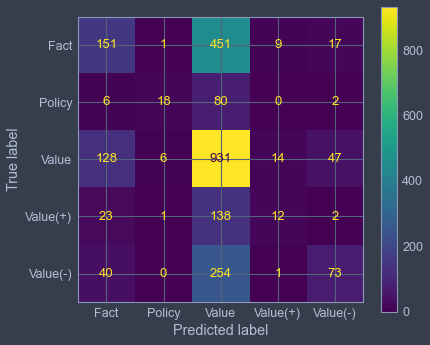

,Precision,Recall,F1
Fact,0.433908,0.240064,0.309110
Policy,0.692308,0.169811,0.272727
Value,0.502157,0.826821,0.624832
Value(+),0.333333,0.068182,0.113208
Value(-),0.517730,0.198370,0.286837


In [15]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

"""
l1-regularization -> 'built-in' feature selection (fewer features)
l2-regularization -> Prefers weight vectors with many small weights
"""

max_iterations = 10**6/np.ceil(X_train.shape[0] / 10) #Empirically,the model converges after 10^6/n where n 
                                        # the size of the test set

sgd_model = SGDClassifier(penalty="l2", 
                          max_iter=np.ceil(max_iterations/10), average=True)
sgd_gs = GridSearchCV(sgd_model, n_jobs=-1, param_grid={
    "alpha": 10.0**-np.arange(1,5),
    "loss": ['log', 'modified_huber']
}, cv=5, scoring="f1_weighted", verbose = 1)

sgd_gs.fit(X_train, y_train)
#sgd_gs.best_score_
print(sgd_gs.best_params_)
print_metrics(y_test, sgd_gs.predict(X_test), sgd_gs.classes_)

In [ ]:
# Linear SVM model -> loss = 'hinge'

sgd_classifier = SGDClassifier(n_jobs=-1, penalty="l2", verbose = 1, shuffle=True, 
                               loss="hinge", max_iter=max_iterations)

sgd_classifier.fit(X_train, y_train)
print_metrics(y_test, sgd_classifier.predict(X_test), sgd_classifier.classes_)

## Linear SVM Classifier
To establish a comparison in terms of performance, we will use the Linear SVM classifier.


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3205
max_resources_: 9616
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 3205
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 3
n_resources: 9615
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LibLinear]Accuracy score:  0.46902286902286905


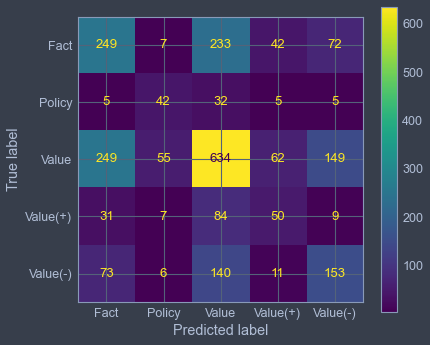

,Precision,Recall,F1
Fact,0.410214,0.412935,0.411570
Policy,0.358974,0.471910,0.407767
Value,0.564559,0.551784,0.558099
Value(+),0.294118,0.276243,0.284900
Value(-),0.394330,0.399478,0.396887


In [26]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC


svm_model = LinearSVC(class_weight="balanced", verbose=1)

svm_gs = HalvingGridSearchCV(svm_model, n_jobs=-1, param_grid = {
    "C": [1,2,5,10],
    "loss": ["hinge", "squared_hinge"]
}, cv=5, scoring="f1_weighted", verbose=3)

svm_gs.fit(X_train, y_train)
print_metrics(y_test, svm_gs.predict(X_test), svm_gs.classes_)

## Logistic Regression Classifier
We can now do the same apply the Logistic Regression classifier and compare it with the previously obtained models with SGD optimization.
